In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly_express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix
pd.options.display.float_format='{:,.2f}'.format
pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [2]:
shipments=pd.read_excel('shipments.xlsx')
customers=pd.read_excel('customers.xlsx')

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   customer_id    1000 non-null   object        
 1   customer_name  1000 non-null   object        
 2   customer_type  1000 non-null   object        
 3   city           1000 non-null   object        
 4   signup_date    1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 39.2+ KB


In [4]:
customers.duplicated().sum()

np.int64(0)

In [5]:
shipmentaandcustomer=shipments.merge(customers,how='inner',on='customer_id')
shipmentaandcustomer['signup_date']=pd.to_datetime(shipmentaandcustomer['signup_date'])

In [6]:
shipmentaandcustomer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   shipment_id    20000 non-null  object        
 1   customer_id    20000 non-null  object        
 2   from_city      20000 non-null  object        
 3   to_city        20000 non-null  object        
 4   weight_kg      20000 non-null  float64       
 5   service_type   20000 non-null  object        
 6   ship_date      20000 non-null  datetime64[ns]
 7   status         20000 non-null  object        
 8   delivery_date  20000 non-null  datetime64[ns]
 9   customer_name  20000 non-null  object        
 10  customer_type  20000 non-null  object        
 11  city           20000 non-null  object        
 12  signup_date    20000 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(9)
memory usage: 2.0+ MB


In [7]:
shipmentaandcustomer.duplicated().sum()

np.int64(0)

In [8]:
shipmentaandcustomer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   shipment_id    20000 non-null  object        
 1   customer_id    20000 non-null  object        
 2   from_city      20000 non-null  object        
 3   to_city        20000 non-null  object        
 4   weight_kg      20000 non-null  float64       
 5   service_type   20000 non-null  object        
 6   ship_date      20000 non-null  datetime64[ns]
 7   status         20000 non-null  object        
 8   delivery_date  20000 non-null  datetime64[ns]
 9   customer_name  20000 non-null  object        
 10  customer_type  20000 non-null  object        
 11  city           20000 non-null  object        
 12  signup_date    20000 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(9)
memory usage: 2.0+ MB


In [9]:
shipmentaandcustomer.sample(5)

,shipment_id,customer_id,from_city,to_city,weight_kg,service_type,ship_date,status,delivery_date,customer_name,customer_type,city,signup_date
10836,SH10836,C1313,Tanta,Giza,10.41,Standard,2024-12-27,Delivered,2024-12-29,Customer_313,Regular,Cairo,2024-08-09
14794,SH14794,C1191,Giza,Mansoura,1.51,Standard,2024-08-21,Delivered,2024-08-23,Customer_191,Regular,Assiut,2024-04-09
2994,SH2994,C1038,Cairo,Cairo,0.39,Standard,2024-07-02,Delivered,2024-07-03,Customer_38,Regular,Tanta,2023-11-08
11242,SH11242,C1593,Assiut,Mansoura,0.08,Express,2024-03-16,Delivered,2024-03-17,Customer_593,Regular,Mansoura,2025-05-16
7683,SH7683,C1236,Assiut,Cairo,3.82,Standard,2024-11-08,Delivered,2024-11-09,Customer_236,Regular,Tanta,2024-05-24


In [10]:
shipmentaandcustomer['status'].unique()

array(['Delivered', 'Delayed'], dtype=object)

In [11]:
#اجمالي عدد الشحنات 
shipmentaandcustomer.shape[0]

20000

In [12]:
#عدد الشحنات حسب الحاله
shipmentaandcustomer.status.value_counts().reset_index()

,status,count
0,Delivered,16099
1,Delayed,3901


In [13]:
#معدل الشحنات المتاخره 
delayed_ratio=(shipmentaandcustomer['status']=='Delayed').mean()*100
print(f"معدل التاخير=  {delayed_ratio}")

معدل التاخير=  19.505


In [14]:
#متوسط مدة التوصيل 
delivered= shipmentaandcustomer[shipmentaandcustomer['status']=='Delivered']
delivered['delivery_dayes']=(delivered['delivery_date']-delivered['ship_date']).dt.days
delivered.groupby('service_type')['delivery_dayes'].mean().reset_index()

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_18496\731034267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered['delivery_dayes']=(delivered['delivery_date']-delivered['ship_date']).dt.days


,service_type,delivery_dayes
0,Express,2.02
1,Same-Day,1.96
2,Standard,1.99


C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_18496\1212194995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered['delivery_dayes']=(delivered['delivery_date']-delivered['ship_date']).dt.days
C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_18496\1212194995.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='service_type', y='delivery_dayes', data=delivered, palette='Blues')


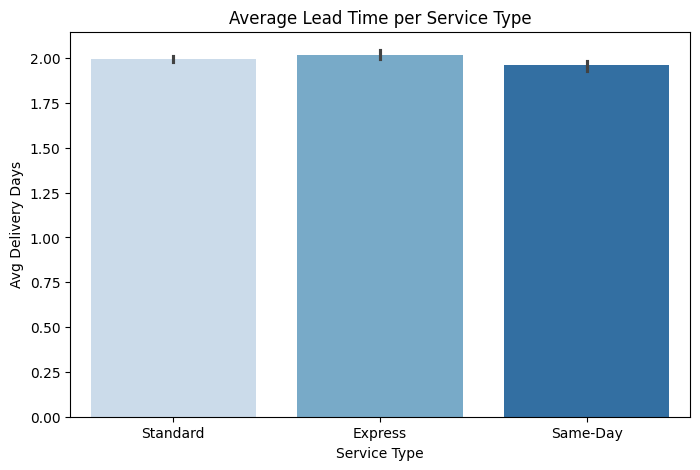

In [15]:
delivered= shipmentaandcustomer[shipmentaandcustomer['status']=='Delivered']
delivered['delivery_dayes']=(delivered['delivery_date']-delivered['ship_date']).dt.days
delivered.groupby('service_type')['delivery_dayes'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='service_type', y='delivery_dayes', data=delivered, palette='Blues')
plt.title('Average Lead Time per Service Type')
plt.ylabel('Avg Delivery Days')
plt.xlabel('Service Type')
plt.show()


In [16]:
delivered.groupby('to_city')['delivery_dayes'].mean().reset_index()

,to_city,delivery_dayes
0,Alexandria,2.01
1,Assiut,1.98
2,Cairo,1.98
3,Giza,1.99
4,Mansoura,2.01
5,Suez,2.01
6,Tanta,2.00
7,Zagazig,1.98


status        Delayed  total  Delayed_%
service_type                           
Express          1202   5822      20.65
Same-Day         1216   4126      29.47
Standard         1483  10052      14.75


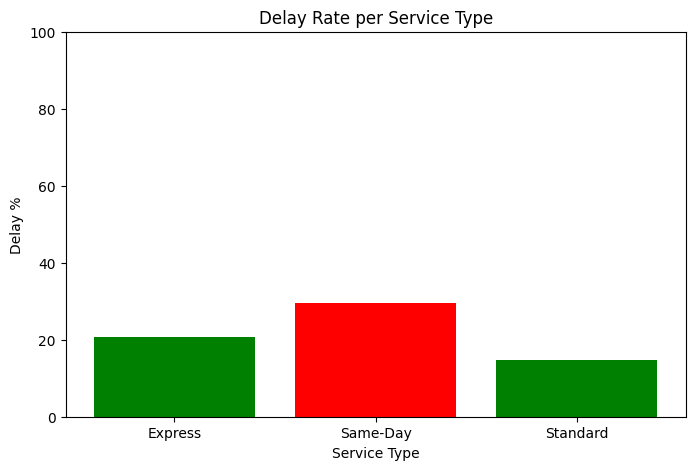

In [17]:
srevice=shipmentaandcustomer.groupby(['status','service_type']).size().reset_index(name='count')
table=srevice.pivot(index='service_type',columns='status',values='count').fillna(0)
table['total']=table.sum(axis=1)
table['Delayed_%']=table['Delayed']/table['total']*100
table[['Delayed','total','Delayed_%']]
print(table[['Delayed','total','Delayed_%']])
plt.figure(figsize=(8, 5))
plt.bar(table.index, table['Delayed_%'],color=['green','red'])
plt.title('Delay Rate per Service Type')
plt.ylabel('Delay %')
plt.xlabel('Service Type')
plt.ylim(0, 100)
plt.show()


اول مشكلة تاخر ال Same-Day
---

In [18]:
city_delay=shipmentaandcustomer[(shipmentaandcustomer['service_type']=='Same-Day')].groupby('to_city')['status'].apply(lambda x:(x=='Delayed').mean()*100).reset_index(name='Delayed_rate')
city_delay.sort_values('Delayed_rate',ascending=False)

,to_city,Delayed_rate
4,Mansoura,33.99
6,Tanta,31.09
2,Cairo,30.49
7,Zagazig,29.94
5,Suez,28.49
3,Giza,28.13
0,Alexandria,27.97
1,Assiut,25.99


C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_18496\867167884.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_delay.sort_values('Delayed_rate',ascending=False),x='to_city', y='Delayed_rate', palette='magma')


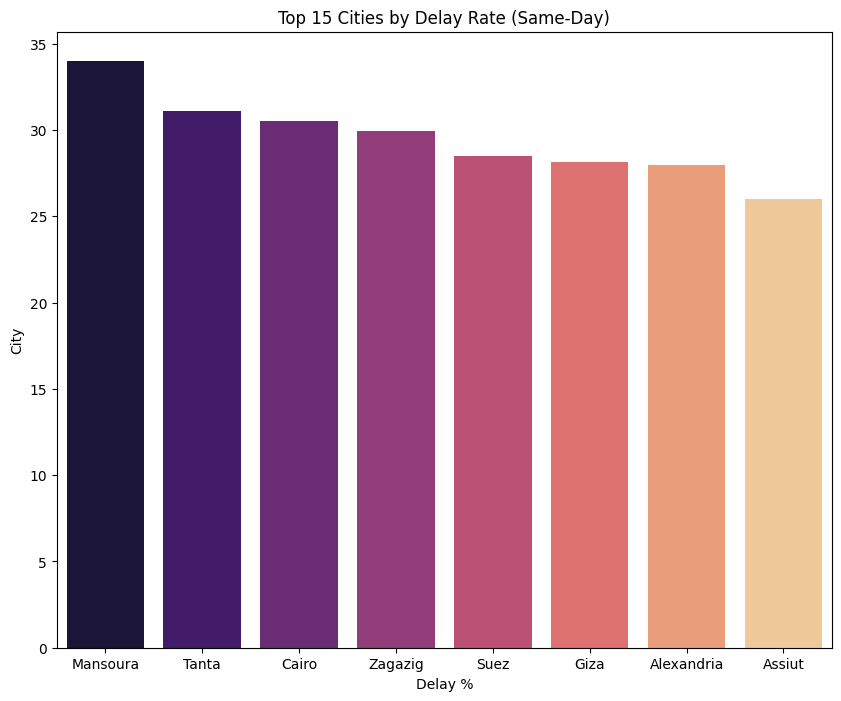

In [19]:
plt.figure(figsize=(10, 8))
sns.barplot(data=city_delay.sort_values('Delayed_rate',ascending=False),x='to_city', y='Delayed_rate', palette='magma')
plt.title('Top 15 Cities by Delay Rate (Same-Day)')
plt.xlabel('Delay %')
plt.ylabel('City')
plt.show()


In [20]:
city_delay=shipmentaandcustomer[(shipmentaandcustomer['service_type']=='Same-Day')].groupby('from_city')['status'].apply(lambda x:(x=='Delayed').mean()*100).reset_index(name='Delayed_rate')
city_delay.sort_values('Delayed_rate',ascending=False)

,from_city,Delayed_rate
3,Giza,30.69
2,Cairo,30.30
4,Tanta,30.12
1,Assiut,30.00
0,Alexandria,26.32


In [21]:
drivers=pd.read_excel('delivery_drivers.xlsx')
delivry_log=pd.read_excel('delivery_logs.xlsx')
delivers=drivers.merge(delivry_log,how='inner',on='driver_id')

In [22]:
delivers.head()

,driver_id,driver_name,region,work_hours,log_id,shipment_id,log_date,duration_min,was_late
0,D0,Driver_0,Alexandria,6,L187,SH187,2024-08-26,25,False
1,D0,Driver_0,Alexandria,6,L300,SH300,2024-04-25,96,False
2,D0,Driver_0,Alexandria,6,L587,SH587,2024-07-31,179,False
3,D0,Driver_0,Alexandria,6,L612,SH612,2024-05-08,28,False
4,D0,Driver_0,Alexandria,6,L708,SH708,2024-10-08,71,False


In [23]:
driver_delay=delivers.groupby('driver_id')['was_late'].mean().sort_values(ascending=False).reset_index().head(10)
driver_delay.rename(columns={'was_late':'delay_rate'})

,driver_id,delay_rate
0,D69,0.25
1,D83,0.25
2,D3,0.25
3,D74,0.25
4,D97,0.25
5,D8,0.24
6,D71,0.24
7,D86,0.23
8,D10,0.23
9,D89,0.23


In [24]:
shcd=shipmentaandcustomer.merge(delivers,how='left',on='shipment_id')

In [25]:
delay_by_driver = shcd[shcd['service_type']=='Same-Day'].groupby('driver_id')['status'].apply(lambda x: (x == 'Delayed').mean()).reset_index(name='delay')
delay_by_driver.sort_values('delay',ascending=False).head(10)

,driver_id,delay
43,D48,0.51
37,D42,0.45
69,D71,0.43
23,D3,0.40
11,D19,0.40
33,D39,0.39
21,D28,0.39
74,D76,0.39
7,D15,0.39
56,D6,0.38


In [26]:
number_of_ship_by_driver=shcd[shcd['service_type']=='Same-Day'].groupby('driver_id')['shipment_id'].count().reset_index(name='count')
number_of_ship_by_driver.sort_values('count',ascending=False).head(10)

,driver_id,count
53,D57,59
18,D25,56
27,D33,52
9,D17,52
5,D13,51
0,D0,50
47,D51,50
75,D77,50
57,D60,49
76,D78,49


In [27]:
driver_perf=number_of_ship_by_driver.merge(delay_by_driver,on='driver_id')
driver_perf.sort_values('delay',ascending=False).head(10)

,driver_id,count,delay
43,D48,37,0.51
37,D42,31,0.45
69,D71,37,0.43
23,D3,47,0.40
11,D19,43,0.40
33,D39,38,0.39
21,D28,41,0.39
74,D76,31,0.39
7,D15,44,0.39
56,D6,39,0.38


In [28]:
drivers_full=driver_perf.merge(drivers[['driver_id','region']],on='driver_id',how='left')
drivers_full.sort_values('delay', ascending=False).tail(10)


,driver_id,count,delay,region
79,D80,39,0.21,Giza
40,D45,46,0.20,Cairo
34,D4,36,0.19,Cairo
9,D17,52,0.19,Alexandria
98,D98,42,0.19,Tanta
38,D43,43,0.19,Cairo
4,D12,33,0.18,Giza
19,D26,33,0.15,Cairo
3,D11,32,0.12,Tanta
49,D53,41,0.12,Giza


In [29]:
sameday=shcd[shcd['service_type']=='Same-Day']
sameday[sameday.status=='Delayed'].shape[0]

1216

In [30]:
num_ship=sameday.groupby('driver_id')['shipment_id'].count().reset_index(name='same_day_shipments')



In [31]:
delay_rate = sameday.groupby('driver_id')['status'].apply(lambda x: (x == 'Delayed').mean()).reset_index(name='delay_same_day')
delay_rate.head(5)


,driver_id,delay_same_day
0,D0,0.28
1,D1,0.24
2,D10,0.32
3,D11,0.12
4,D12,0.18


In [32]:
total_shipments=shcd.groupby('driver_id')['shipment_id'].count().reset_index(name="total_shipments")

In [33]:
overall_delay=shcd.groupby('driver_id')['status'].apply(lambda x:(x=='Delayed').mean()).reset_index(name="overall_delay")

In [34]:
total_same_day_delay = sameday['status'].value_counts().get('Delayed', 0)
delay_contribution= sameday[sameday['status']=='Delayed'].groupby('driver_id')['shipment_id'].count().reset_index(name='delayed_shipments')
delay_contribution['delay_share']=(delay_contribution['delayed_shipments']/total_same_day_delay)*100
delay_contribution.head(5)

,driver_id,delayed_shipments,delay_share
0,D0,14,1.15
1,D1,9,0.74
2,D10,14,1.15
3,D11,4,0.33
4,D12,6,0.49


In [35]:
driver_performance= num_ship.merge(delay_rate,on='driver_id',how='outer')\
                    .merge(total_shipments,on='driver_id',how='outer')\
                    .merge(overall_delay,on='driver_id',how='outer')\
                    .merge(delay_contribution,on='driver_id',how='left')\
                    .merge(drivers[['driver_id','region']],on='driver_id',how='left')

In [36]:
driver_performance.head(5)


,driver_id,same_day_shipments,delay_same_day,total_shipments,overall_delay,delayed_shipments,delay_share,region
0,D0,50,0.28,207,0.19,14,1.15,Alexandria
1,D1,37,0.24,198,0.19,9,0.74,Tanta
2,D10,44,0.32,195,0.23,14,1.15,Tanta
3,D11,32,0.12,189,0.22,4,0.33,Tanta
4,D12,33,0.18,167,0.11,6,0.49,Giza


In [37]:
def classify_driver(driver):
    if driver['delay_same_day'] >= 0.39 and driver['same_day_shipments'] < 40:
        return 'poor performance (not overloaded)'
    elif driver['delay_same_day'] >= 0.39 and driver['same_day_shipments'] > 40:
        return 'poor performance (overloaded)'
    elif driver['delay_same_day'] < 0.2 and driver['same_day_shipments'] > 40:
        return 'good & efficient'
    else:
        return 'good'

driver_performance['category']=driver_performance.apply(classify_driver,axis=1)
top10=driver_performance.sort_values('delay_same_day',ascending=False).head(10)
tow_var=top10[['driver_id','same_day_shipments','delay_same_day']]
top10

,driver_id,same_day_shipments,delay_same_day,total_shipments,overall_delay,delayed_shipments,delay_share,region,category
43,D48,37,0.51,208,0.20,19,1.56,Giza,poor performance (not overloaded)
37,D42,31,0.45,189,0.22,14,1.15,Alexandria,poor performance (not overloaded)
69,D71,37,0.43,182,0.24,16,1.32,Tanta,poor performance (not overloaded)
23,D3,47,0.40,192,0.25,19,1.56,Assiut,poor performance (overloaded)
11,D19,43,0.40,201,0.21,17,1.40,Alexandria,poor performance (overloaded)
33,D39,38,0.39,210,0.20,15,1.23,Cairo,poor performance (not overloaded)
21,D28,41,0.39,204,0.19,16,1.32,Alexandria,poor performance (overloaded)
74,D76,31,0.39,194,0.16,12,0.99,Giza,good
7,D15,44,0.39,207,0.21,17,1.40,Assiut,good
56,D6,39,0.38,199,0.21,15,1.23,Alexandria,good


In [38]:
fig=px.bar(tow_var,x='driver_id',y=['same_day_shipments','delay_same_day'],title='Driver_performance',labels={'value':'Value','driver_id':'Driver_ID'},color_discrete_map=None,barmode='group',text_auto=True)
fig.update_layout(
    
    yaxis=dict(title='num_shipments', range=[0, tow_var['same_day_shipments'].max() * 1.2]),
    yaxis2=dict(title='delay%', overlaying='y', side='right', range=[0, 0.91]),
    legend_title_text='Legend'
)
fig.for_each_trace(lambda x:x.update(yaxis='y2')if x.name =='delay_same_day'else())
fig.show()

In [39]:
shcd['ship_month']=shcd['ship_date'].dt.to_period('M')
monthly_shipments=shcd.groupby(['driver_id','ship_month'])['shipment_id'].count().reset_index(name='monthly_shipments')
top_loaded=monthly_shipments.sort_values('monthly_shipments',ascending=False).head(10)
least_loaded=monthly_shipments.sort_values('monthly_shipments',ascending=True).head(10)


In [40]:
avg_monthly = monthly_shipments.groupby('driver_id')['monthly_shipments'].mean().reset_index(name='avg_monthly_shipments')
avg_monthly.sort_values('avg_monthly_shipments', ascending=False).head(10)


,driver_id,avg_monthly_shipments
9,D17,19.33
99,D99,19.33
53,D57,19.17
61,D64,19.08
20,D27,19.00
77,D79,18.92
10,D18,18.92
51,D55,18.83
65,D68,18.67
27,D33,18.67


In [41]:
issues=pd.read_excel('service_issues.xlsx')
all_issues=issues.merge(shcd,how='left',on='shipment_id')
all_issues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   issue_id       500 non-null    object        
 1   shipment_id    500 non-null    object        
 2   issue_type     500 non-null    object        
 3   reported_date  500 non-null    datetime64[ns]
 4   customer_id    500 non-null    object        
 5   from_city      500 non-null    object        
 6   to_city        500 non-null    object        
 7   weight_kg      500 non-null    float64       
 8   service_type   500 non-null    object        
 9   ship_date      500 non-null    datetime64[ns]
 10  status         500 non-null    object        
 11  delivery_date  500 non-null    datetime64[ns]
 12  customer_name  500 non-null    object        
 13  customer_type  500 non-null    object        
 14  city           500 non-null    object        
 15  signup_date    500 non-

In [42]:
num_ship_issues=issues['issue_id'].nunique()
total_shipments = shipments['shipment_id'].nunique()

issues_rate=(num_ship_issues/total_shipments)*100
print(f"Service Issue Rate = {issues_rate:.2f}%")

Service Issue Rate = 2.50%


In [43]:
num_issues_type=all_issues['issue_type'].value_counts().reset_index(name='count')
num_issues_type

px.pie(data_frame=num_issues_type,names='issue_type',values='count')

In [44]:
all_issues['to_city'].value_counts()


to_city
Mansoura      68
Alexandria    67
Zagazig       64
Tanta         64
Cairo         63
Giza          60
Assiut        58
Suez          56
Name: count, dtype: int64

In [45]:
all_issues.service_type.value_counts()


service_type
Standard    240
Express     152
Same-Day    108
Name: count, dtype: int64

In [46]:
all_issues['driver_id'].value_counts().head(10)

driver_id
D77    11
D37    10
D32    10
D51     9
D26     9
D64     9
D8      9
D99     9
D36     8
D95     8
Name: count, dtype: int64

In [47]:
all_issues['customer_type'].value_counts().head(10)

customer_type
Regular    363
VIP        137
Name: count, dtype: int64

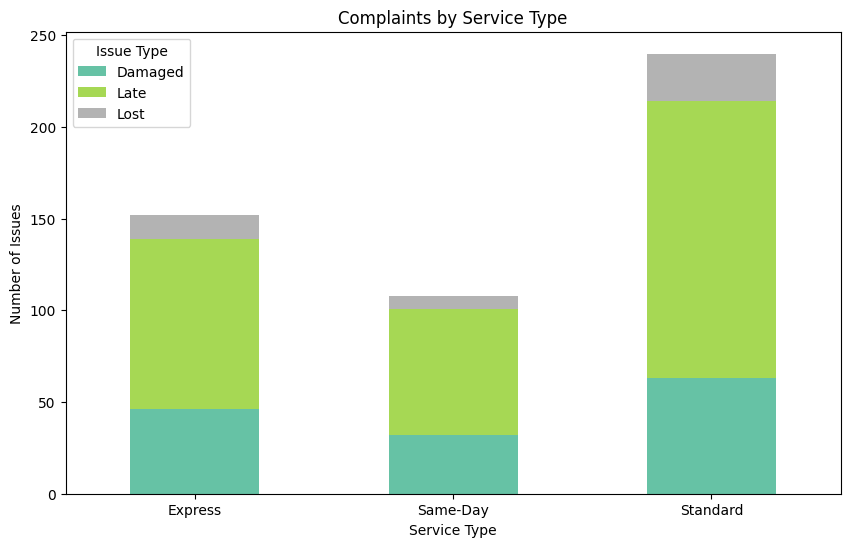

In [48]:
aa=all_issues.groupby(['service_type','issue_type'])['issue_id'].size().reset_index(name='count')
aa=aa.pivot(index='service_type',columns='issue_type',values='count')
aa['total']=aa.sum(axis=1)
aa[['Damaged','Late','Lost']].plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')
plt.title('Complaints by Service Type')
plt.ylabel('Number of Issues')
plt.xlabel('Service Type')
plt.xticks(rotation=0)
plt.legend(title='Issue Type')
plt.show()



In [49]:
same_day_issues = all_issues[all_issues['service_type'] == 'Same-Day'].shape[0]
same_day_total = shipments[shipments['service_type'] == 'Same-Day'].shape[0]
same_day_rate=     same_day_issues/same_day_total*100
same_day_rate

2.617547261269995

In [50]:
shcd['is_delayed']=(shcd.status=='Delayed').astype(int)
shcd.head(5)

,shipment_id,customer_id,from_city,to_city,weight_kg,service_type,ship_date,status,delivery_date,customer_name,customer_type,city,signup_date,driver_id,driver_name,region,work_hours,log_id,log_date,duration_min,was_late,ship_month,is_delayed
0,SH0,C1102,Giza,Tanta,6.42,Standard,2024-11-30,Delivered,2024-12-01,Customer_102,Regular,Alexandria,2024-01-11,D86,Driver_86,Giza,9,L0,2024-12-01,56,False,2024-11,0
1,SH1,C1435,Alexandria,Assiut,5.53,Standard,2024-01-16,Delivered,2024-01-19,Customer_435,Regular,Mansoura,2024-12-09,D80,Driver_80,Giza,6,L1,2024-01-19,103,False,2024-01,0
2,SH2,C1860,Tanta,Giza,0.58,Standard,2024-01-08,Delivered,2024-01-10,Customer_860,VIP,Suez,2026-02-07,D41,Driver_41,Cairo,7,L2,2024-01-10,177,False,2024-01,0
3,SH3,C1270,Cairo,Tanta,26.45,Standard,2024-11-12,Delayed,2024-11-17,Customer_270,Regular,Giza,2024-06-27,D34,Driver_34,Cairo,8,L3,2024-11-17,159,True,2024-11,1
4,SH4,C1106,Assiut,Giza,0.88,Same-Day,2024-04-01,Delayed,2024-04-06,Customer_106,Regular,Assiut,2024-01-15,D51,Driver_51,Assiut,6,L4,2024-04-06,117,True,2024-04,1


In [51]:
shipments=pd.read_excel('shipments.xlsx')
customers=pd.read_excel('customers.xlsx')
drivers = pd.read_excel('delivery_drivers.xlsx')
logs = pd.read_excel('delivery_logs.xlsx')
data=shipments.merge(customers,on='customer_id',how='left')\
               .merge(logs,on='shipment_id',how='left')\
               .merge(drivers[['driver_id','region']],on='driver_id',how='left')

In [52]:
data.head(5)

,shipment_id,customer_id,from_city,to_city,weight_kg,service_type,ship_date,status,delivery_date,customer_name,customer_type,city,signup_date,log_id,driver_id,log_date,duration_min,was_late,region
0,SH0,C1102,Giza,Tanta,6.42,Standard,2024-11-30,Delivered,2024-12-01,Customer_102,Regular,Alexandria,2024-01-11,L0,D86,2024-12-01,56,False,Giza
1,SH1,C1435,Alexandria,Assiut,5.53,Standard,2024-01-16,Delivered,2024-01-19,Customer_435,Regular,Mansoura,2024-12-09,L1,D80,2024-01-19,103,False,Giza
2,SH2,C1860,Tanta,Giza,0.58,Standard,2024-01-08,Delivered,2024-01-10,Customer_860,VIP,Suez,2026-02-07,L2,D41,2024-01-10,177,False,Cairo
3,SH3,C1270,Cairo,Tanta,26.45,Standard,2024-11-12,Delayed,2024-11-17,Customer_270,Regular,Giza,2024-06-27,L3,D34,2024-11-17,159,True,Cairo
4,SH4,C1106,Assiut,Giza,0.88,Same-Day,2024-04-01,Delayed,2024-04-06,Customer_106,Regular,Assiut,2024-01-15,L4,D51,2024-04-06,117,True,Assiut


In [53]:
data['is_delayed']=data['status'].apply(lambda x:1 if x =='Delayed' else 0)

In [54]:
features =['service_type', 'from_city', 'to_city', 'customer_type', 'driver_id', 'region', 'weight_kg']
target='is_delayed'

In [60]:
label_cols=['service_type', 'from_city', 'to_city', 'customer_type','region','driver_id']
X =data[features]
y=data[target]
le_dict={}
for col in label_cols:
    le=LabelEncoder()
    X[col]=le.fit_transform(X[col])
    le_dict[col]=le

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_18496\3930084614.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_18496\3930084614.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mr.Omar\AppData\Local\Temp\ipykernel_18496\3930084614.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [71]:
X_train , X_test , y_train , y_test=train_test_split(X ,y,test_size=0.2,random_state=42)
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train)
model=RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train_res,y_train_res)
y_pred=model.predict(X_test)
print('classification_report')
print(classification_report(y_test,y_pred))

classification_report
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      3237
           1       0.22      0.29      0.25       763

    accuracy                           0.67      4000
   macro avg       0.52      0.52      0.52      4000
weighted avg       0.71      0.67      0.69      4000



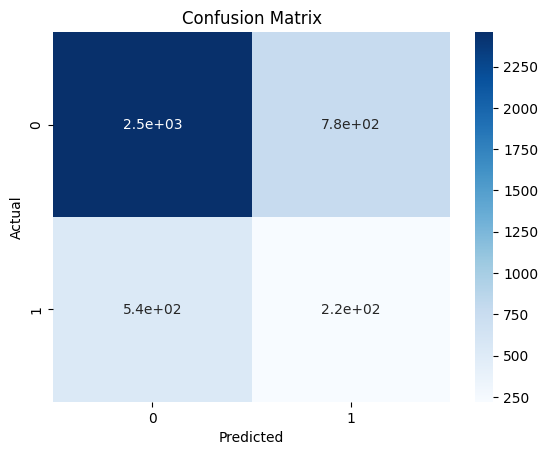

In [72]:
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<BarContainer object of 7 artists>

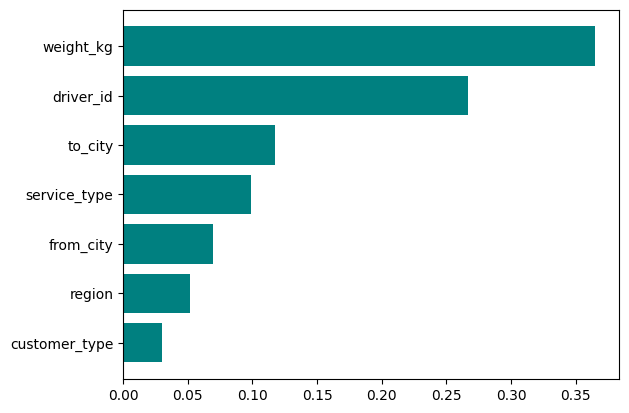

In [87]:
feature_names = X.columns
importances=model.feature_importances_
feat=pd.DataFrame({
    'Features':feature_names,
    'Importance':importances
}).sort_values('Importance',ascending=True)
plt.barh(feat['Features'],feat['Importance'],color='teal')